In [ ]:
#@markdown Upload an image to the base folder and set the image_name into the image file name
image_name = 'leo.png' #@param {type:"string"}

Aligned image has shape: (256, 256)


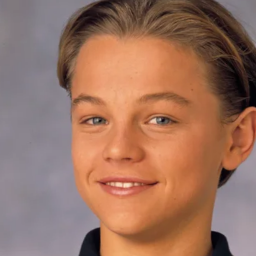

In [ ]:
import numpy as np
import PIL
import PIL.Image
import scipy
import scipy.ndimage
import dlib


def get_landmark(filepath, predictor):
    """get landmark with dlib
    :return: np.array shape=(68, 2)
    """
    detector = dlib.get_frontal_face_detector()

    img = dlib.load_rgb_image(filepath)
    dets = detector(img, 1)

    for k, d in enumerate(dets):
        shape = predictor(img, d)

    t = list(shape.parts())
    a = []
    for tt in t:
        a.append([tt.x, tt.y])
    lm = np.array(a)
    return lm


def align_face(filepath, predictor):
    """
    :param filepath: str
    :return: PIL Image
    """

    lm = get_landmark(filepath, predictor)

    lm_chin = lm[0: 17]  # left-right
    lm_eyebrow_left = lm[17: 22]  # left-right
    lm_eyebrow_right = lm[22: 27]  # left-right
    lm_nose = lm[27: 31]  # top-down
    lm_nostrils = lm[31: 36]  # top-down
    lm_eye_left = lm[36: 42]  # left-clockwise
    lm_eye_right = lm[42: 48]  # left-clockwise
    lm_mouth_outer = lm[48: 60]  # left-clockwise
    lm_mouth_inner = lm[60: 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left = np.mean(lm_eye_left, axis=0)
    eye_right = np.mean(lm_eye_right, axis=0)
    eye_avg = (eye_left + eye_right) * 0.5
    eye_to_eye = eye_right - eye_left
    mouth_left = lm_mouth_outer[0]
    mouth_right = lm_mouth_outer[6]
    mouth_avg = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # read image
    img = PIL.Image.open(filepath)

    output_size = 256
    transform_size = 256
    enable_padding = True

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
            int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
            min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
           int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
           max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
                          1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    # Return aligned image.
    return img

#@title
from PIL import Image
import os
image_path = image_name
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

input_image = run_alignment(image_path)

input_image.resize((256, 256))